<img src="https://www.nyp.edu.sg/content/dam/nyp/logo.png" height='200' width='200'/>

Welcome to the lab! Before we get started here are a few pointers on Jupyter notebooks.

1. The notebook is composed of cells; cells can contain code which you can run, or they can hold text and/or images which are there for you to read.

2. You can execute code cells by clicking the ```Run``` icon in the menu, or via the following keyboard shortcuts ```Shift-Enter``` (run and advance) or ```Ctrl-Enter``` (run and stay in the current cell).

3. To interrupt cell execution, click the ```Stop``` button on the toolbar or navigate to the ```Kernel``` menu, and select ```Interrupt ```.
    


# Anomaly Detection for Network Traffic
                                                             
<center>
    <img src="resources/intrusion_alert.png" height="400" width="400" style="vertical-align:middle;margin:10px 20px"/><center>
                

In this lab, we will try to build an anomaly detector for network traffic, which can detect attack traffic such as Denial of Service (DoS), Heartbleed, etc. We will make use of two pre-processed network traffic files, which contain features extracted from the raw traffic. These features are extracted from TCP and UDP flows. One file contains only normal traffic, which we will use for training an Autoencoder neural network. The other file contains mixture of normal and attack traffic, which we will use for fine-tuning the threshold of anomaly score, and for testing.  



## Import libraries

We begin by importing the libraries that we need, mainly the scikit-learn (which contains some useful methods for scaling the data, and  for calculating various evaluation metrics, such as precision/recall scores), the tensorflow (which is the framework that we use to build the autoencoder neural network) and matplotlib (which we use for data visualization)

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import mse
import sys
from utils2 import *
from utils import *

## Getting the data

We download the data that we need for this lab. The is a zip file which contain csv files for different days of network traffic data. After download, the files are unzipped to a directory called ```'ids_dataset'```. You should be able to see the directory at the left sidebar (file browser). 


In [2]:
base_dataset_dir = 'ids_dataset'
datafile_url = 'https://sdaaidata.s3-ap-southeast-1.amazonaws.com/datasets/ids_dataset.zip'
download_data(base_dataset_dir, datafile_url, extract=True, force=False)

dataset directory already exists, skip download


For this lab exercise, we will the following two files: 

1. Monday-WorkingHours.pcap_ISCX.csv - contains features extracted from normal traffic 
2. Wednesday-workingHours.pcap_ISCX - contains a mixture of normal traffic and attack traffic such as DoS/DDoS, Heartbleed, slowloris, Goldeneye, etc.  

We use the pandas library to read data from CSV files into panda dataframe (dataframe is a 2D data structure similar to database table, which contains columns and rows. Row represents individual data sample, and columns are the different features of the data sample) 

In [3]:
normal_traffic = os.path.join(base_dataset_dir, 'Monday-WorkingHours.pcap_ISCX.csv')
mixed_traffic = os.path.join(base_dataset_dir, 'Wednesday-workingHours.pcap_ISCX.csv')

df_normal = pd.read_csv(normal_traffic)
df_mixed = pd.read_csv(mixed_traffic)

## Data Exploration 

Let us examine the data a bit more. We use info() method to get more information about the features (columns) and the row count for each column, as well as the data type of the column (feature). We see from the display below, that we have 78 features (column 0-77) and the last column (78) is the label of the traffic.

In [4]:
df_normal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529918 entries, 0 to 529917
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             529918 non-null  int64  
 1    Flow Duration                529918 non-null  int64  
 2    Total Fwd Packets            529918 non-null  int64  
 3    Total Backward Packets       529918 non-null  int64  
 4   Total Length of Fwd Packets   529918 non-null  int64  
 5    Total Length of Bwd Packets  529918 non-null  int64  
 6    Fwd Packet Length Max        529918 non-null  int64  
 7    Fwd Packet Length Min        529918 non-null  int64  
 8    Fwd Packet Length Mean       529918 non-null  float64
 9    Fwd Packet Length Std        529918 non-null  float64
 10  Bwd Packet Length Max         529918 non-null  int64  
 11   Bwd Packet Length Min        529918 non-null  int64  
 12   Bwd Packet Length Mean       529918 non-nul

From the above display, we can see that there a few rows that have missing values for ```Flow Bytes/s```. There are 529854 rows which have non-null values for ```Flow Bytes/s```, compared to others that have 529918 non-null rows. That means there are 64 empty values (or NaN, Not-a-Number, in ML jargon).

Let's us take a look at the values of the target label to see what are different values for the label. 


In [5]:
df_normal[' Label'].value_counts()

BENIGN    529918
Name:  Label, dtype: int64


Since this dataset only contains 'normal' traffic, the label should only one value 'BENIGN'. Let us also find out what type of labels we have for mixed_traffic.

**Exercise**

In the following cell, modify the codes to display the types of labels we have for mixed traffic data. What are different types of attack traffic? 

<details><summary>Click here for answer</summary> 
<br/>
    
```
df_mixed[' Label'].value_counts()
```
    
<br/>
From the display, we see that most of the attack traffic are DoS Hulk, the rest being DoS GoldenEye, DoS slowloris, DoS Slowhttptest, and Heartbleed.
    
</details>

In [6]:
df_mixed[' Label'].value_counts()

BENIGN              440031
DoS Hulk            231073
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name:  Label, dtype: int64

Let us also now take a look at the statistics of the different feature columns to have some ideas of the numeric values we are dealing with. 

In [7]:
pd.set_option('display.max_rows', 500)
df_normal.describe().T

,count,mean,std,min,25%,50%,75%,max
Destination Port,529918.0,1.064437e+04,2.139021e+04,0.000000e+00,53.000000,80.000000,443.000000,6.553500e+04
Flow Duration,529918.0,1.038927e+07,2.875195e+07,-1.000000e+00,176.000000,31303.000000,355744.750000,1.200000e+08
Total Fwd Packets,529918.0,1.039032e+01,8.924128e+02,1.000000e+00,2.000000,2.000000,4.000000,2.197590e+05
Total Backward Packets,529918.0,1.151710e+01,1.173319e+03,0.000000e+00,1.000000,2.000000,3.000000,2.919220e+05
Total Length of Fwd Packets,529918.0,5.324195e+02,6.228642e+03,0.000000e+00,18.000000,68.000000,187.000000,1.323378e+06
Total Length of Bwd Packets,529918.0,1.789841e+04,2.675470e+06,0.000000e+00,0.000000,144.000000,392.000000,6.554530e+08
Fwd Packet Length Max,529918.0,1.908972e+02,4.488338e+02,0.000000e+00,6.000000,40.000000,83.000000,2.336000e+04
Fwd Packet Length Min,529918.0,2.027728e+01,3.627579e+01,0.000000e+00,0.000000,6.000000,40.000000,2.293000e+03
Fwd Packet Length Mean,529918.0,5.074408e+01,9.196471e+01,0.000000e+00,6.000000,38.000000,53.000000,4.638923e+03
Fwd Packet Length Std,529918.0,5.745227e+01,1.465181e+02,0.000000e+00,0.000000,0.000000,26.162951,7.125597e+03


From the display, we can see that there are a few feature columns that have infinite values (as determined by CICFlowMeter). 

**Exercise**

Can you identify which columns? 

<details><summary>Click here for answer</summary> 
<br/>
    
The columns ```Flow Bytes/s``` and ```Flow Packets/s``` have **inf** as max value, and thus also have **inf** as mean amd stardard deviation.  
    
<br/>
From the display, we see that most of the attack traffic are DoS Hulk, the rest being DoS GoldenEye, DoS slowloris, DoS Slowhttptest, and Heartbleed.
    
</details>

**Exercise** 

Now modify the codes below to examine the values of df_mixed. Are there any abnormal values as in `df_normal`

<details><summary>Click here for answer</summary> 
<br/>

```
df_mixed.describe().T
```

<br/>
    
The columns ```Flow Bytes/s``` and ```Flow Packets/s``` also contain inf as max value.
    
</details>

In [8]:
df_mixed.describe().T

,count,mean,std,min,25%,50%,75%,max
Destination Port,692703.0,5.686869e+03,1.572742e+04,0.0,53.000000,80.000000,4.430000e+02,6.548700e+04
Flow Duration,692703.0,2.800168e+07,4.276680e+07,-1.0,201.000000,61437.000000,8.302437e+07,1.200000e+08
Total Fwd Packets,692703.0,9.556261e+00,7.471978e+02,1.0,2.000000,2.000000,7.000000e+00,2.039430e+05
Total Backward Packets,692703.0,1.021408e+01,9.842046e+02,0.0,1.000000,2.000000,6.000000e+00,2.723530e+05
Total Length of Fwd Packets,692703.0,5.550930e+02,6.163663e+03,0.0,12.000000,82.000000,3.650000e+02,1.224076e+06
Total Length of Bwd Packets,692703.0,1.699644e+04,2.241175e+06,0.0,0.000000,188.000000,1.159500e+04,6.270000e+08
Fwd Packet Length Max,692703.0,2.335939e+02,6.037519e+02,0.0,6.000000,46.000000,3.410000e+02,2.482000e+04
Fwd Packet Length Min,692703.0,1.502218e+01,5.106883e+01,0.0,0.000000,0.000000,3.200000e+01,2.065000e+03
Fwd Packet Length Mean,692703.0,6.055544e+01,1.576438e+02,0.0,6.000000,41.000000,5.666667e+01,4.640758e+03
Fwd Packet Length Std,692703.0,8.289586e+01,2.261261e+02,0.0,0.000000,0.000000,1.289169e+02,6.429191e+03


## Data Cleaning 

We will need to clean up the data by removing the NaN values and the Infinite values.  Since we don't have too many rows of 'NaN' and 'inf' values, the easiest way is to drop them. The code below first tells pandas to treat Inf values as NaN ('mode.use_inf_as_na') and then drops all rows that contains NaN values (effectively dropping both rows with NaN and Inf values)

In [9]:
with pd.option_context('mode.use_inf_as_na', True):
    df_normal = df_normal.dropna(subset=['Flow Bytes/s', ' Flow Packets/s'], how='all')
    df_mixed = df_mixed.dropna(subset=['Flow Bytes/s', ' Flow Packets/s'], how='all')

## Data Preparation

### Combining the attack labels 

In this exercise, we are only interested in detection if the traffic is normal or 'abnormal', so we will group all the differnt attack types into just one label, and we will label them as '1' while the benign traffic will be labelled as 0

In [10]:
df_normal[' Label'] = df_normal[' Label'].apply(lambda x: 1 if x != 'BENIGN' else 0)
df_mixed[' Label'] = df_mixed[' Label'].apply(lambda x: 1 if x != 'BENIGN' else 0)

Now let's see our new traffic labels for df_mixed. We should see that they now have only two values 0 or 1.

In [11]:
df_mixed[' Label'].value_counts()

0    439683
1    251723
Name:  Label, dtype: int64

### Create Training Set and Validation Set

Here we will create the training set and the validation set. We will use the normal-only traffic (df_normal) as training and validation set. Since we are using unsupervised learning, we do not need the 'Label', so we will drop the label column during training.

In [12]:
df_normal_nolabel = df_normal.drop([' Label'], axis=1)

X_train, X_val = train_test_split(df_normal_nolabel, test_size=0.2, shuffle=True)

### Crate Test Set

Here we split the mixed traffic into 'tuning' set (df_tune) and test set (df_test).  We will use the 'tuning' set to help us fine tune our anomaly score threshold to achieve the desired precision/recall goal. We will then test our fine-tuned anomaly detector on the test set.

In [13]:
df_tune, df_test = train_test_split(df_mixed, test_size=0.5, shuffle=True, stratify=df_mixed[' Label'])

In the code below, we will separate the label, which we will call ``y_val`` and ``y_test`` from the features, which we call ``X_val`` and ``X_test`` .

***Note***: Although we do not need label in unsupervised learning, in this case, we will keep the labels and use them to evaluate our model.

In [14]:
y_tune = df_tune[' Label']
X_tune = df_tune.drop(' Label', axis=1)

In [15]:
y_test = df_test[' Label']
X_test = df_test.drop(' Label', axis=1)

### Scaling the data 

The last step we need in our Data Preparation is to scale the data by removing the mean and scaling to unit variance. Most machine learning algorithms (including neural networks) required data to be scaled to be able to learn better. Note that we compute the mean and standard deviation (std) from the **training set only** and use the computed mean and std to scale the test set and the validation set. This is to prevent information leakage from validation/test set to training set. 

In [16]:
from sklearn.preprocessing import RobustScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [17]:
X_val_scaled = scaler.transform(X_val)
X_tune_scaled = scaler.transform(X_tune)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Good to make sure that our training set does not contain any NaN values, just in case, before we start training
assert not np.any(np.isnan(X_train_scaled))

Congratulations, we have finished our data preparation !!! As in all machine learning projects, data preparation is always the **most** time consuming phase.

## Build the Variational Autoencoder (VAE)

In [19]:
# we set the input dimensions to the number of features in X, i.e. 78.  
input_dim = X_train.shape[1]
latent_dim = 20

### Encoder

We will now build the Encoder part of the Variational Autoencoder. One main difference between a Variational Autoencoder and a normal Autoencoder is the VAE learns the mean and the standard deviation of the inputs, basically learning the distribution of the inputs. It will then sample from this learnt distribution to produce codings that will be used by the decoder to produce an output.

<img src="resources/vae_encoder.png" height='500' width='500'>

In the following code, ```codings_mean``` is the mean, and the ```log_var``` is the log of variance (instead of using standard deviation, it is mathematically easier to use log of variance, for computation purpose) learnt. ```Sampling()``` is a function used to sample from the learnt distribution

In [20]:
inputs = Input(shape=(input_dim,), name='Input')
z = Dense(80, activation='tanh', name='hidden1')(inputs)
z = Dense(64, activation='tanh', name='hidden2')(z)
z = Dense(32, activation='tanh', name='hidden3')(z)
codings_mean = Dense(latent_dim, name='mean')(z)
codings_log_var = Dense(latent_dim, name='log_var')(z)
codings = Sampling()([codings_mean, codings_log_var])
vae_encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

vae_encoder.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 78)]         0                                            
__________________________________________________________________________________________________
hidden1 (Dense)                 (None, 80)           6320        Input[0][0]                      
__________________________________________________________________________________________________
hidden2 (Dense)                 (None, 64)           5184        hidden1[0][0]                    
__________________________________________________________________________________________________
hidden3 (Dense)                 (None, 32)           2080        hidden2[0][0]                    
_______________________________________________________________________________________

In [21]:
#plot_model(vae_encoder, to_file='model.png', expand_nested=True,show_shapes=True, dpi=282)

### Decoder

Here, we will build the Decoder part of the VAE. 

<img src="resources/vae_decoder.png" height="500" width="500"/>

In [22]:
decoder_inputs = Input(shape=[latent_dim], name='codings')
x = Dense(32, activation='tanh', name='hidden4')(decoder_inputs)
x = Dense(64, activation='tanh', name='hidden5')(x)
x = Dense(80, activation='tanh', name='hidden6')(x)
outputs = Dense(input_dim, activation="linear", name='output')(x)
vae_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])
vae_decoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
codings (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
hidden4 (Dense)              (None, 32)                672       
_________________________________________________________________
hidden5 (Dense)              (None, 64)                2112      
_________________________________________________________________
hidden6 (Dense)              (None, 80)                5200      
_________________________________________________________________
output (Dense)               (None, 78)                6318      
Total params: 14,302
Trainable params: 14,302
Non-trainable params: 0
_________________________________________________________________


In [23]:
X_train_scaled = X_train_scaled.astype(np.float32)

In [24]:
_, _, codings = vae_encoder(inputs)
reconstructions = vae_decoder(codings)
vae = Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)

reconstruction_loss = losses.mse(inputs, reconstructions)
reconstruction_loss *= input_dim
vae_loss = K.mean(latent_loss + reconstruction_loss)
vae.add_loss(vae_loss)
rmsprop = RMSprop()
vae.compile(loss='mean_squared_error', optimizer=rmsprop, metrics=['mean_squared_error'])


In [25]:
vae.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 78)]         0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       [(None, 20), (None,  14904       Input[0][0]                      
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 78)           14302       functional_1[0][2]               
__________________________________________________________________________________________________
hidden1 (Dense)                 (None, 80)           6320        Input[0][0]                      
_______________________________________________________________________________________

In [26]:
train = True
num_epochs = 100
batch_size = 512
save_model = False

if train:     
    run_logdir = get_run_logdir() # e.g., './my_logs/run_2019_06_07-15_15_22'
    tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
    history = vae.fit(X_train_scaled, X_train_scaled, 
                      epochs=num_epochs, 
                      batch_size=batch_size, 
                      verbose=1, 
                      shuffle=True,
                      validation_data = (X_val_scaled, X_val_scaled),
                      callbacks=[tensorboard_cb])
    
    if save_model: 
        vae.save('trained_model')
else:
    vae = tf.keras.models.load_model('trained_model')

Epoch 1/100
  1/828 [..............................] - ETA: 0s - loss: 73.1978 - mean_squared_error: 0.8890WARNING:tensorflow:From C:\Users\markk\anaconda3\envs\tf2env\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
828/828 [==============================] - 3s 3ms/step - loss: 42.9526 - mean_squared_error: 0.4702 - val_loss: 69.7385 - val_mean_squared_error: 0.8087
Epoch 2/100
828/828 [==============================] - 3s 3ms/step - loss: 31.7272 - mean_squared_error: 0.3300 - val_loss: 64.4287 - val_mean_squared_error: 0.7440
Epoch 3/100
828/828 [==============================] - 3s 3ms/step - loss: 28.6668 - mean_squared_error: 0.2942 - val_loss: 62.0318 - val_mean_squared_error: 0.7170
Epoch 4/100
828/828 [==============================] - 3s 3ms/step - loss: 27.1057 - mean_squared_error: 0.2761 - va

Now we are ready to train our auto-encoder

Now we will plot the training loss

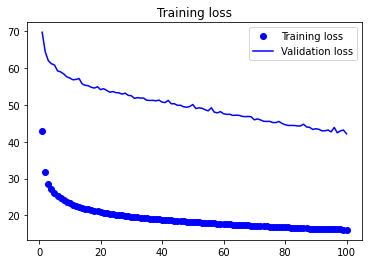

In [27]:
## plot the training loss
if train:
    plot_training_loss(history)

### Test the Anomaly Detector on Test Dataset

Now let us compare the reconstruction error between training set (the clean, benign traffic) and that of test set (the one with attack traffic). 

In [28]:
X_train_preds = vae.predict(X_train_scaled)

In [29]:
X_train_mse  =   np.square(X_train_scaled - X_train_preds).mean()
print(X_train_mse)

0.14968304


In [30]:
X_tune_preds = vae.predict(X_tune_scaled)
X_tune_mse = np.square(X_tune_scaled - X_tune_preds).mean()
print(X_tune_mse)

1.820702547893427


From above, we can see that the MSE (the mean squared error) for the test set is much much than the training set. The presence of attack traffic make it more difficult for Variational Autoencoder to reconstruct the input more accurately.

### Compute the distance between Train set and the test set. 

Now let us compute the 'difference' between each sample and its reconstructed version. As each sample is a multi-demensional vector, the difference will be multi-dimensional as well. Therefore we will use the Frobenius norm to measure the distance between the sample and its reconstruction.  In the following np.linalg.norm() will compute the ```Frobenius norm```.  

In [34]:
X_train_preds = vae.predict(X_train_scaled)
X_train_errors = np.linalg.norm(X_train_scaled - X_train_preds, axis=1)
print('min = ',X_train_errors.min())
print('max = ',X_train_errors.max())
print('mean = ',X_train_errors.mean())
print('std = ',X_train_errors.std())

min =  0.158939
max =  821.51184
mean =  1.5072973
std =  3.066612


In [35]:
X_tune_preds = vae.predict(X_tune_scaled)
X_tune_errors = np.linalg.norm(X_tune_scaled - X_tune_preds, axis=1)
print('min = ', X_tune_errors.min())
print('max = ',X_tune_errors.max())
print('mean = ',X_tune_errors.mean())
print('std = ', X_tune_errors.std())

min =  0.19829956902762377
max =  741.2924453184706
mean =  6.4039932870135265
std =  10.04508311501712


In [36]:
X_test_preds = vae.predict(X_test_scaled)
X_test_errors = np.linalg.norm(X_test_scaled - X_test_preds, axis=1)
print('min = ', X_test_errors.min())
print('max = ',X_test_errors.max())
print('mean = ',X_test_errors.mean())
print('std = ', X_test_errors.std())

min =  0.21752905785860854
max =  754.1054892370348
mean =  6.415966974365039
std =  10.240702043306642


## Setting the Threshold

Based on above, it seems reasonable to set the threshold at train mean + 3 train std deviation. In the absence of labels to help us adjust threshold for the anomaly detector, we could the threshold derived by statistical means.

In [38]:
threshold = X_train_errors.mean() + 3 * X_train_errors.std()
print(threshold)

10.707133293151855


Let us use this threshold on the test set

In [39]:
#threshold= 1.9
z = zip(X_test_errors > threshold, X_test_errors)
y_label=[]
error = []
for idx, (is_anomaly, X_test_error) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(X_test_error)
precision = precision_score(y_test, y_label, pos_label=1)
recall = recall_score(y_test, y_label, pos_label=1)
accuracy = accuracy_score(y_test, y_label)
print('threshold={:.2f}, precision={}, recall={}, acc={}'.format(threshold, precision, recall, accuracy))

threshold=10.71, precision=0.9698424700693131, recall=0.6114395131175414, acc=0.8516125113175183


Let's just plot the data points. The normal data is marked green and the abnormal data is marked as red. The current threshold is shown as blue horizontal line. As there are close to 350,000 data points, it will be difficult to visualize on the graph. Let's us just plot first 1000 data points to see how the errors of each data point

y counts 0    642
1    358
Name:  Label, dtype: int64


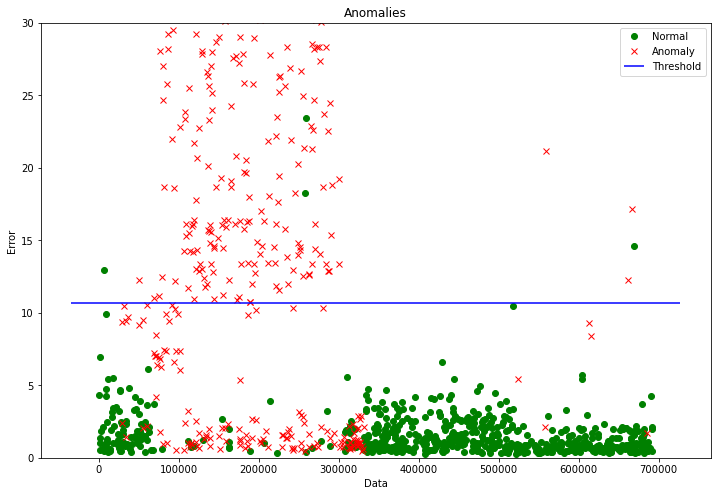

In [40]:
draw_anomaly(y_test[:1000], X_test_errors[:1000], threshold)

**Exercise**

You can change the threshold above to see how it affects the precision and recall

If you increase the threshold, you increase the precision but decrease the recall (sensitivity).

Now we have used the validation set to help us find the threshold to use, let see how effective is this on the test set.

In [44]:
threshold = 3

X_test_preds = vae.predict(X_test_scaled)
X_test_errors = np.linalg.norm(X_test_scaled - X_test_preds, axis=1)

z = zip(X_test_errors > threshold, X_test_errors)
y_label=[]
error = []
for idx, (is_anomaly, X_test_error) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(X_test_error)
precision = precision_score(y_test, y_label, pos_label=1)
recall = recall_score(y_test, y_label, pos_label=1)
accuracy = accuracy_score(y_test, y_label)
print('threshold={:.2f}, precision={}, recall={}, acc={}'.format(threshold, precision, recall, accuracy))

threshold=3.00, precision=0.7832301010963976, recall=0.6992579174015986, acc=0.8200478445370737
